# Projeto de Redes Neurais: Classificação de Borboletas

Guilherme Henrique Rodrigues RA: 290200


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guigez/butterflies-classification/blob/main/Projeto_de_Redes_Neurais_Classifica%C3%A7%C3%A3o_de_borboletas.ipynb)

1. [Introdução](#Introdução)

    1.1 [Preparação do Ambiente](#Preparação-do-Ambiente)
       
2. [Exploração e Organização dos Dados](#Exploração-e-Organização-dos-Dados)

    2.1 [Organizando as imagens](#Organizando-as-imagens)

    2.2 [Explorando os dados](#Exxplorando-os-dados)

3. [Pré-processamento e Divisão dos Dados](#Pré-processamento)  
4. [Desenvolvimento e Treinamento do Modelo](#Desenvolvimento-e-Treinamento-do-Modelo)

    4.1 [Rede neural convolucional personalizada](#Rede-neural-convulacional-personalizada)

    4.2 [Tranfer Learning com Resnet18](#Tranfer-Learning-com-Resnet18)

    4.3 [Treinamento](#Treinamento)  

5. [Avaliação e Explicabilidade](#Avaliação-e-Explicabilidade)

    5.1 [Explicabilidade](#Explicabilidade) 

# Introdução

Este projeto tem como objetivo desenvolver um modelo de rede neural para a classificação de imagens de borboletas em diferentes espécies. A classificação de imagens é uma tarefa fundamental em visão computacional e possui aplicações em áreas como biologia, conservação ambiental e educação.


## Contextualização dos Dados

Os dados utilizados neste projeto foram obtidos a partir do repositório [Butterfly Image Classification](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/data) no Kaggle. Este conjunto de dados inclui:

* 75 classes diferentes de borboletas, cada uma representando uma espécie distinta.
* Mais de 1000 imagens rotuladas, incluindo imagens para validação.
* Cada imagem pertence exclusivamente a uma única categoria de borboleta.

Os rótulos das imagens estão organizados em um arquivos CSV:

**Training_set.csv:** Contém os nomes das imagens e suas respectivas categorias para o treinamento do modelo.

## Abordagem do Projeto

Para alcançar o objetivo de classificar corretamente as borboletas, seguimos as seguintes etapas:

* Preparação do Ambiente: Configuração do ambiente de execução utilizando o Google Colab e dispositivos de GPU, quando disponíveis, para acelerar o processamento.

* Organização e Exploração dos Dados: Carregamento e inspeção do conjunto de dados para garantir que as imagens estejam devidamente organizadas e que as categorias sejam consistentes.

* Pré-processamento e Divisão dos Dados: Aplicação de técnicas de transformação e normalização, vistos em sala de aula, para melhorar a qualidade dos dados e aumentar a robustez do modelo ao lidar com variações e separação dos dados em conjuntos de treino, validação e teste, permitindo o treinamento e a avaliação adequada do modelo.

* Desenvolvimento e Treinamento do Modelo: Implementação de uma rede neural convolucional personalizada para a classificação de imagens e de uma rede neural com traferencia de apendizado com Resnet18, seguida de treinamento.

* Avaliação e Explicabilidade:

## Preparação do Ambiente

In [77]:
# Bibliotecas

import os
import shap
import torch
import shutil
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


from pathlib import Path
# from google.colab import drive
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [78]:
# Escolhendo o device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Usando {device}")

Usando cuda


In [79]:
# Montando drive para pegar as pastas
# drive.mount('/content/drive')

# Organização e Exploração dos Dados

In [80]:
# # Caminho para o diretório base com o uso de Google Colaba
# base_dir = '/content/drive/My Drive/Colab Notebooks/Redes Neurais/Projeto/Dados'

# # Caminho para os dados originais
# original_dir = os.path.join(base_dir, 'Dados Originais')

# original_data_dir = os.path.join(original_dir, 'train')

# labels_csv_path = os.path.join(original_dir, 'Training_set.csv')

# data_dir = os.path.join(base_dir, 'Dados Organizados/butterflies')

In [81]:
# Caminho do diretorio de dados - uso local
data_dir = 'Dados Organizados/butterflies'

## Organizando as imagens

In [82]:
# # Lê o arquivo CSV
# train_set = pd.read_csv(labels_csv_path)

# # Extrai as labels únicas
# labels = train_set['label'].unique()

In [83]:
# # Cria as pastas para cada label

# for label in labels:
#   label_images_dir = os.path.join(data_dir, label)
#   Path(label_images_dir).mkdir(parents=True, exist_ok=True)

In [84]:
# # Organizando imagens nas classes correspondentes
# # Mover as imagens para suas respectivas pastas

# for index, row in train_set.iterrows():
#     filename = row['filename']
#     label = row['label']

#     # Caminho completo da imagem na pasta original
#     source = os.path.join(original_data_dir, filename)

#     # Caminho de destino dentro da pasta da label correspondente
#     destination = os.path.join(data_dir, label, filename)

#     # Move a imagem para a pasta correta
#     if os.path.exists(source):
#         shutil.copyfile(source, destination)
#     else:
#         print(f"Imagem {filename} não encontrada.")

## Explorando os dados

In [85]:
# !ls '/content/drive/My Drive/Colab Notebooks/Redes Neurais/Projeto/Dados/Dados Organizados/butterflies'

                       Classe  Número de Imagens
0                      ADONIS                 88
1   AFRICAN GIANT SWALLOWTAIL                 75
2              AMERICAN SNOOT                 74
3                       AN 88                 85
4                     APPOLLO                 90
..                        ...                ...
70                     ULYSES                 84
71                    VICEROY                 81
72                 WOOD SATYR                 71
73        YELLOW SWALLOW TAIL                 75
74            ZEBRA LONG WING                 76

[75 rows x 2 columns]


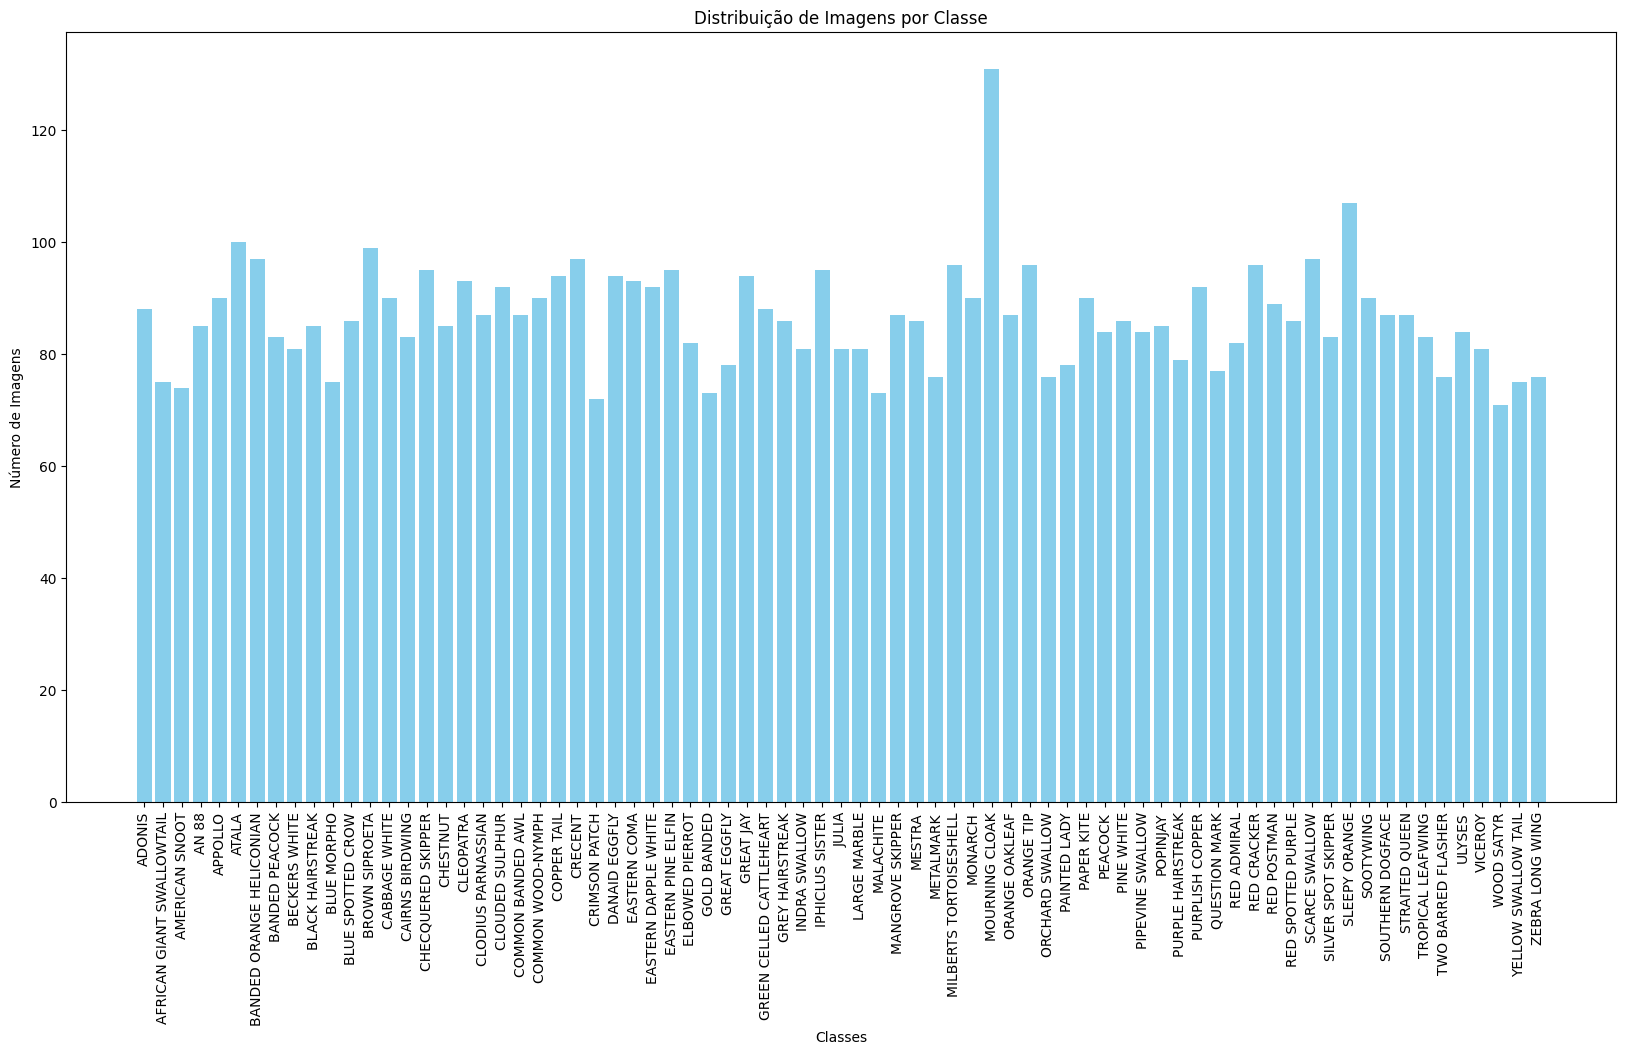

In [ ]:
# Dicionário para armazenar a contagem
class_counts = {}

# Contar imagens por classe
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Criar um DataFrame para visualização
class_df = pd.DataFrame(list(class_counts.items()), columns=["Classe", "Número de Imagens"])
print(class_df)

# Gráfico de barras para visualizarcao dos dados por classes
plt.figure(figsize=(20, 10))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xlabel("Classes")
plt.ylabel("Número de Imagens")
plt.title("Distribuição de Imagens por Classe")
plt.xticks(rotation=90)
plt.show()

# Pré-processamento e Divisão dos Dados

In [86]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

## Definindo os tamanhos dos bancos
train_size = int(0.8 * len(dataset))
val_size   = int(0.1 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(
    train_dataset, batch_size=32,
    shuffle=True, pin_memory = True,
    num_workers=2, persistent_workers = True
    )

val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False, pin_memory = True,
    num_workers=2, persistent_workers = True
    )

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, pin_memory = True,
    num_workers=2, persistent_workers = True
    )

# Desenvolvimento e Treinamento do Modelo

In [87]:
def evaluate(model, loader, criterion) :
    model.eval()  # Entrando no modo de avaliação
    running_loss = 0.0
    pred_list, label_list = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim = 1).cpu().numpy()

            pred_list.extend(predicted)
            label_list.extend(labels.cpu().numpy())

    loss = running_loss/len(loader)

    return loss, pred_list, label_list

In [ ]:
def train_model(model, criterion, evaluate, optimizer, train_loader, val_loader, num_epochs = 30, patience = 5, name_model = 'best_model'):
    best_val_loss = np.inf
    early_stop_count = 0

    # Listas para salvar métricas
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Entrando no modo de treino
        running_loss = 0.0

        # Iterando sobre os batches de dados
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            classes = labels
            acurracy_test = accuracy_score(classes.to('cpu'), preds.to('cpu'))
    
        train_loss = running_loss/len(train_loader)
        val_loss, val_preds, val_labels = evaluate(model, val_loader, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}:\n\tTrain Loss: {train_loss:.4f}\n\tVal Loss: {val_loss:.4f}\n")

        # Armazenar métricas
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(acurracy_test)
        val_accuracies.append(accuracy_score(val_labels, val_preds))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_count = 0
            torch.save(model.state_dict(), f'{name_model}.pth')
            print(f"Melhor modelo salvo com val_loss: {best_val_loss:.4f}\n")
        else :
            early_stop_count += 1
            if early_stop_count >= patience:
                print(f"Treino parado por EarlyStopping após {epoch+1} épocas")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [89]:
def print_metrics(y_true, y_pred):
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    print('Accuracy: {:.4f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1 Score: {:.4f}'.format(fscore))

In [90]:
def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
  # Gráfico de Perda
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Treino')
  plt.plot(val_losses, label='Validação')
  plt.title('Perda durante o Treinamento')
  plt.xlabel('Época')
  plt.ylabel('Perda')
  plt.legend()

  # Gráfico de Acurácia
  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label='Treino')
  plt.plot(val_accuracies, label='Validação')
  plt.title('Acurácia durante o Treinamento')
  plt.xlabel('Época')
  plt.ylabel('Acurácia')
  plt.legend()

  plt.tight_layout()
  plt.show()

## Rede neural convolucional personalizada

In [91]:
class ButterflyCNN(nn.Module):
    def __init__(self) -> None:
        super(ButterflyCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch Normalization para a primeira camada convolucional
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.25),  # Dropout após a primeira camada convolucional

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Batch Normalization para a segunda camada convolucional
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # nn.Dropout(p=0.5),  # Dropout após a segunda camada convolucional

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 64 filtros para 128 filtros
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p=0.25),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 128 filtros para 256 filtros
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            # nn.Dropout(p=0.25)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.BatchNorm1d(512),  # Batch Normalization para a camada totalmente conectada
            nn.ReLU(),
            # nn.Dropout(p=0.5),  # Dropout após a primeira camada totalmente conectada
            nn.Linear(512, len(dataset.classes))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 256 * 8 * 8)  # Achata o tensor para o tamanho necessário na camada totalmente conectada
        x = self.fc_layers(x)

        return x

## Tranfer Learning com Resnet18

In [92]:
model_ButterflyTransfer = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar os Pesoas da Resnet18
for param in model_ButterflyTransfer.parameters():
  param.requires_grad = False

# Trocar útima camada
num_ftrs = model_ButterflyTransfer.fc.in_features

# Substituindo a camada de saída
model_ButterflyTransfer.fc = nn.Linear(num_ftrs, len(dataset.classes))

## Treinamento

Epoch 1/30:
	Train Loss: 3.0368
	Val Loss: 2.3761

Melhor modelo salvo com val_loss: 2.3761

Epoch 2/30:
	Train Loss: 1.9390
	Val Loss: 1.8780

Melhor modelo salvo com val_loss: 1.8780

Epoch 3/30:
	Train Loss: 1.4163
	Val Loss: 1.4192

Melhor modelo salvo com val_loss: 1.4192

Epoch 4/30:
	Train Loss: 1.0977
	Val Loss: 1.2971

Melhor modelo salvo com val_loss: 1.2971

Epoch 5/30:
	Train Loss: 0.8523
	Val Loss: 1.1912

Melhor modelo salvo com val_loss: 1.1912

Epoch 6/30:
	Train Loss: 0.7063
	Val Loss: 1.1369

Melhor modelo salvo com val_loss: 1.1369

Epoch 7/30:
	Train Loss: 0.5502
	Val Loss: 1.0824

Melhor modelo salvo com val_loss: 1.0824

Epoch 8/30:
	Train Loss: 0.4823
	Val Loss: 1.0456

Melhor modelo salvo com val_loss: 1.0456

Epoch 9/30:
	Train Loss: 0.3783
	Val Loss: 0.9834

Melhor modelo salvo com val_loss: 0.9834

Epoch 10/30:
	Train Loss: 0.3447
	Val Loss: 1.0091

Epoch 11/30:
	Train Loss: 0.2886
	Val Loss: 0.9252

Melhor modelo salvo com val_loss: 0.9252

Epoch 12/30:
	Tra

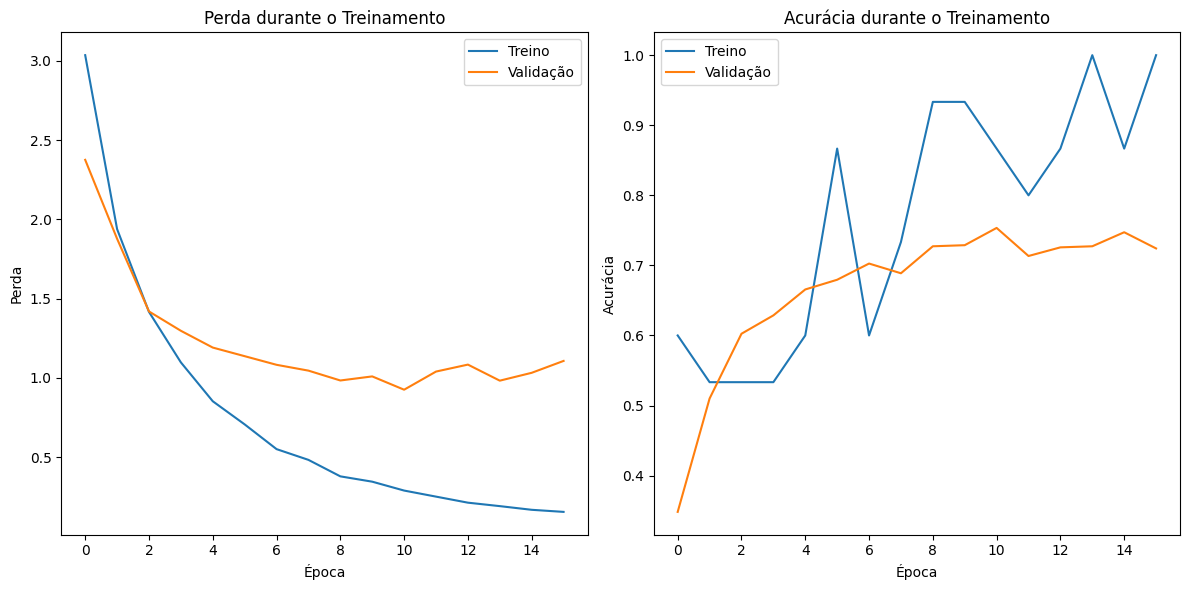

In [93]:
model_ButterflyCNN = ButterflyCNN().to(device)

# Taxa de apendizado
learning_rate = 0.001

# Função de custo
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = optim.Adam(model_ButterflyCNN.parameters(), lr=learning_rate)

train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn = train_model(model_ButterflyCNN, criterion, evaluate, optimizer, train_loader, val_loader, name_model='model_ButterflyCNN')

plot_training_metrics(train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn)

Epoch 1/30:
	Train Loss: 3.0001
	Val Loss: 1.9445

Melhor modelo salvo com val_loss: 1.9445

Epoch 2/30:
	Train Loss: 1.6538
	Val Loss: 1.5343

Melhor modelo salvo com val_loss: 1.5343

Epoch 3/30:
	Train Loss: 1.2933
	Val Loss: 1.2733

Melhor modelo salvo com val_loss: 1.2733

Epoch 4/30:
	Train Loss: 1.0956
	Val Loss: 1.1190

Melhor modelo salvo com val_loss: 1.1190

Epoch 5/30:
	Train Loss: 1.0003
	Val Loss: 1.1698

Epoch 6/30:
	Train Loss: 0.9274
	Val Loss: 1.1383

Epoch 7/30:
	Train Loss: 0.8765
	Val Loss: 1.0748

Melhor modelo salvo com val_loss: 1.0748

Epoch 8/30:
	Train Loss: 0.8187
	Val Loss: 1.0289

Melhor modelo salvo com val_loss: 1.0289

Epoch 9/30:
	Train Loss: 0.7720
	Val Loss: 1.0546

Epoch 10/30:
	Train Loss: 0.7547
	Val Loss: 1.0226

Melhor modelo salvo com val_loss: 1.0226

Epoch 11/30:
	Train Loss: 0.7237
	Val Loss: 1.0402

Epoch 12/30:
	Train Loss: 0.7144
	Val Loss: 1.0189

Melhor modelo salvo com val_loss: 1.0189

Epoch 13/30:
	Train Loss: 0.6898
	Val Loss: 1.031

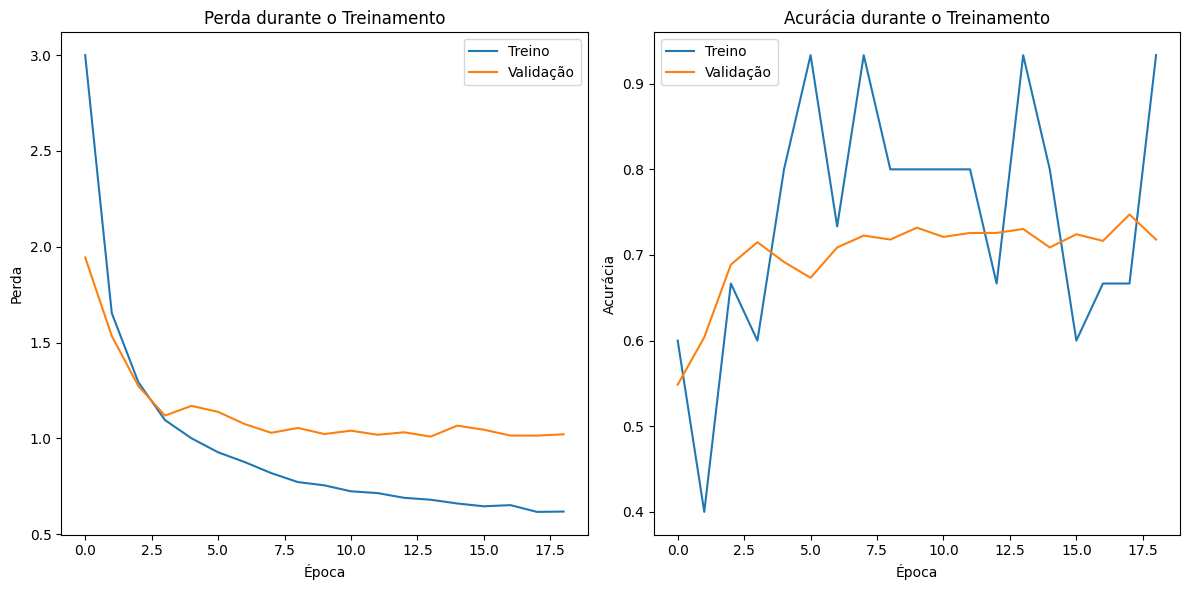

In [94]:
model_ButterflyTransfer.to(device)

# Taxa de apendizado
learning_rate_transfer = 0.001

# Função de custo
criterion_transfer = nn.CrossEntropyLoss()

# Otimizador
optimizer_transfer = optim.Adam(model_ButterflyTransfer.fc.parameters(), lr=learning_rate_transfer)

train_losses_transfer, val_losses_transfer, train_accuracies_transfer, val_accuracies_transfer =train_model(model_ButterflyTransfer, criterion_transfer, evaluate, optimizer_transfer, train_loader, val_loader, name_model="model_ButterflyTransfer")

plot_training_metrics(train_losses_transfer, val_losses_transfer, train_accuracies_transfer, val_accuracies_transfer)

# Avaliação e Explicabilidade

In [95]:
model_ButterflyCNN.load_state_dict(torch.load('model_ButterflyCNN.pth', weights_only=True))

train_loss, train_preds, train_labels = evaluate(model_ButterflyCNN, train_loader, criterion)
val_loss, val_preds, val_labels = evaluate(model_ButterflyCNN, val_loader, criterion)
test_loss, test_preds, test_labels = evaluate(model_ButterflyCNN, test_loader, criterion)

print("Avaliação do Treino")
print_metrics(train_labels, train_preds)

print("\nAvaliação do Validação")
print_metrics(val_labels, val_preds)

print("\nAvaliação do Teste")
print_metrics(test_labels, test_preds)


Avaliação do Treino
Accuracy: 0.9575
Precision: 0.9600
Recall: 0.9573
F1 Score: 0.9575

Avaliação do Validação
Accuracy: 0.7350
Precision: 0.7603
Recall: 0.7303
F1 Score: 0.7250

Avaliação do Teste
Accuracy: 0.7757
Precision: 0.7838
Recall: 0.7845
F1 Score: 0.7673


In [99]:
model_ButterflyTransfer.load_state_dict(torch.load('model_ButterflyTransfer.pth', weights_only=True))

train_loss, train_preds, train_labels = evaluate(model_ButterflyTransfer, train_loader, criterion_transfer)
val_loss, val_preds, val_labels = evaluate(model_ButterflyTransfer, val_loader, criterion_transfer)
test_loss, test_preds, test_labels = evaluate(model_ButterflyTransfer, test_loader, criterion_transfer)


print("Avaliação do Treino")
print_metrics(train_labels, train_preds)

print("\nAvaliação do Validação")
print_metrics(val_labels, val_preds)

print("\nAvaliação do Teste")
print_metrics(test_labels, test_preds)

Avaliação do Treino
Accuracy: 0.8400
Precision: 0.8527
Recall: 0.8375
F1 Score: 0.8367

Avaliação do Validação
Accuracy: 0.7411
Precision: 0.7587
Recall: 0.7448
F1 Score: 0.7258

Avaliação do Teste
Accuracy: 0.7819
Precision: 0.7993
Recall: 0.7792
F1 Score: 0.7745


## Explicabilidade

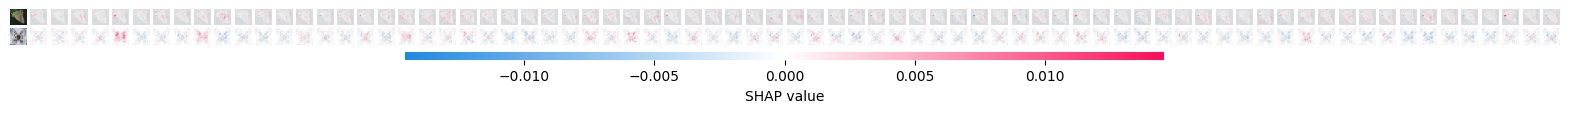

<Figure size 1200x1000 with 0 Axes>

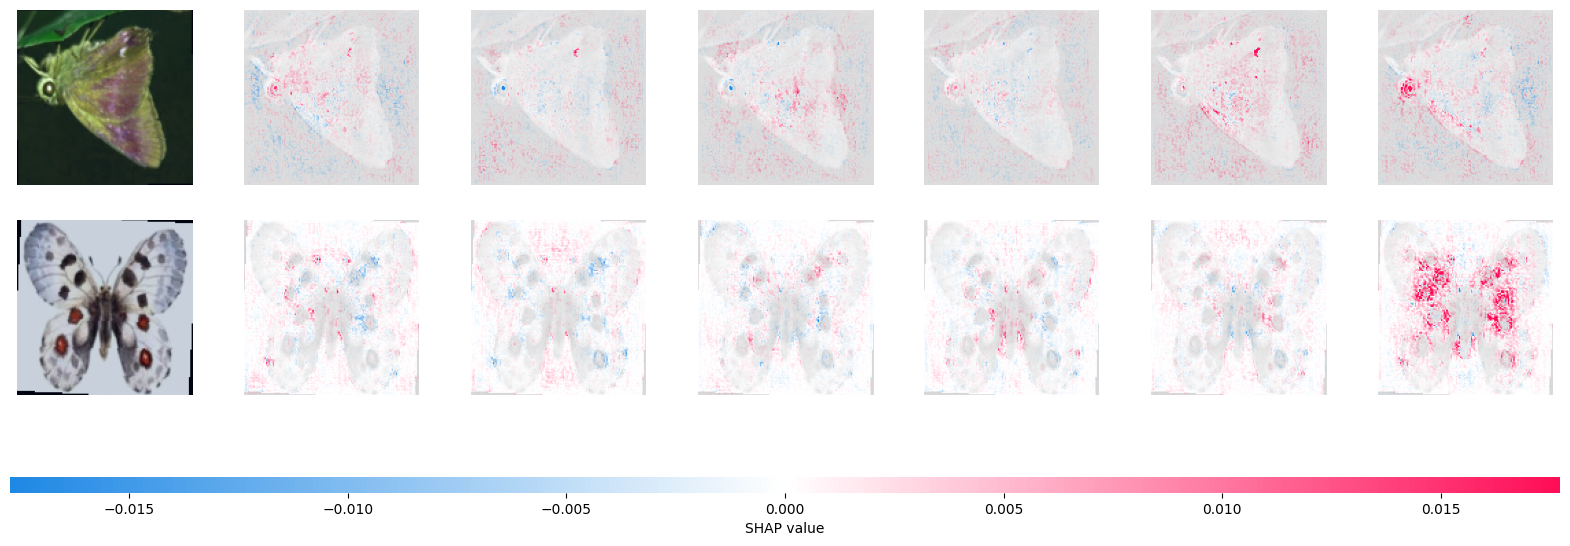

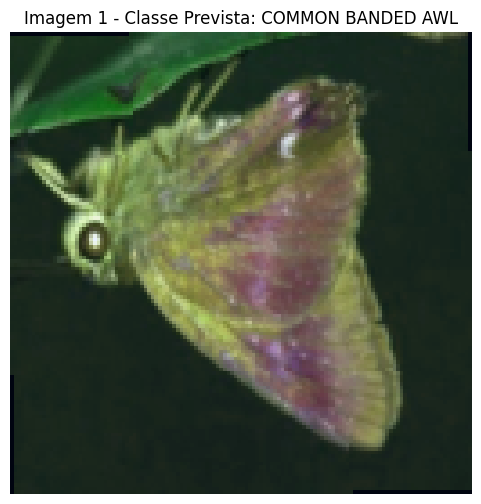

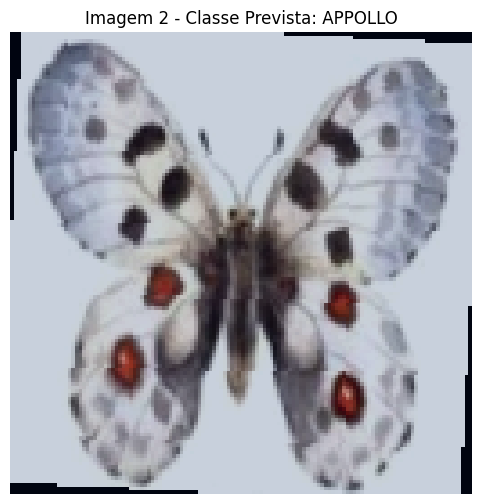

In [97]:
# Como shuffle=false, estamos pegando em sequência os batches do banco de dados de teste.
batch = next(iter(test_loader))
images, _ = batch
images = images.to(device)

background  = images[:30]
test_images = images[30:]

e = shap.DeepExplainer(model_ButterflyCNN, background)
shap_values = e.shap_values(test_images)

shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.to("cpu").numpy(), 1, -1), 1, 2)

# Normalizando os dados para o intervalo de 0 a 1
test_numpy = (test_numpy - np.min(test_numpy)) / (np.max(test_numpy) - np.min(test_numpy))

# Plotando os valores de Shapley para cada Feature
shap.image_plot(shap_numpy, test_numpy)

# Fazer previsões com o modelo
model_ButterflyCNN.eval()
with torch.no_grad():
    outputs = model_ButterflyCNN(test_images)

# Identificar as classes previstas
predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy()

selected_classes = [0, 1, 2, 3, predicted_classes[0], predicted_classes[1]]
shap_numpy_subset = [shap_numpy[class_idx] for class_idx in selected_classes]

# Plotar para essas classes
plt.figure(figsize=(12, 10))
shap.image_plot(shap_numpy_subset, test_numpy)

for i in range(len(test_numpy)):
    plt.figure(figsize=(6, 6))
    plt.imshow(test_numpy[i])
    #plt.imshow(shap_numpy[i].mean(axis=0), cmap='coolwarm', alpha=0.6)
    plt.title(f"Imagem {i+1} - Classe Prevista: {dataset.classes[predicted_classes[i]]}")
    plt.axis('off')
    plt.show()